In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE

from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('training.csv')
df_test = pd.read_csv('test.csv')

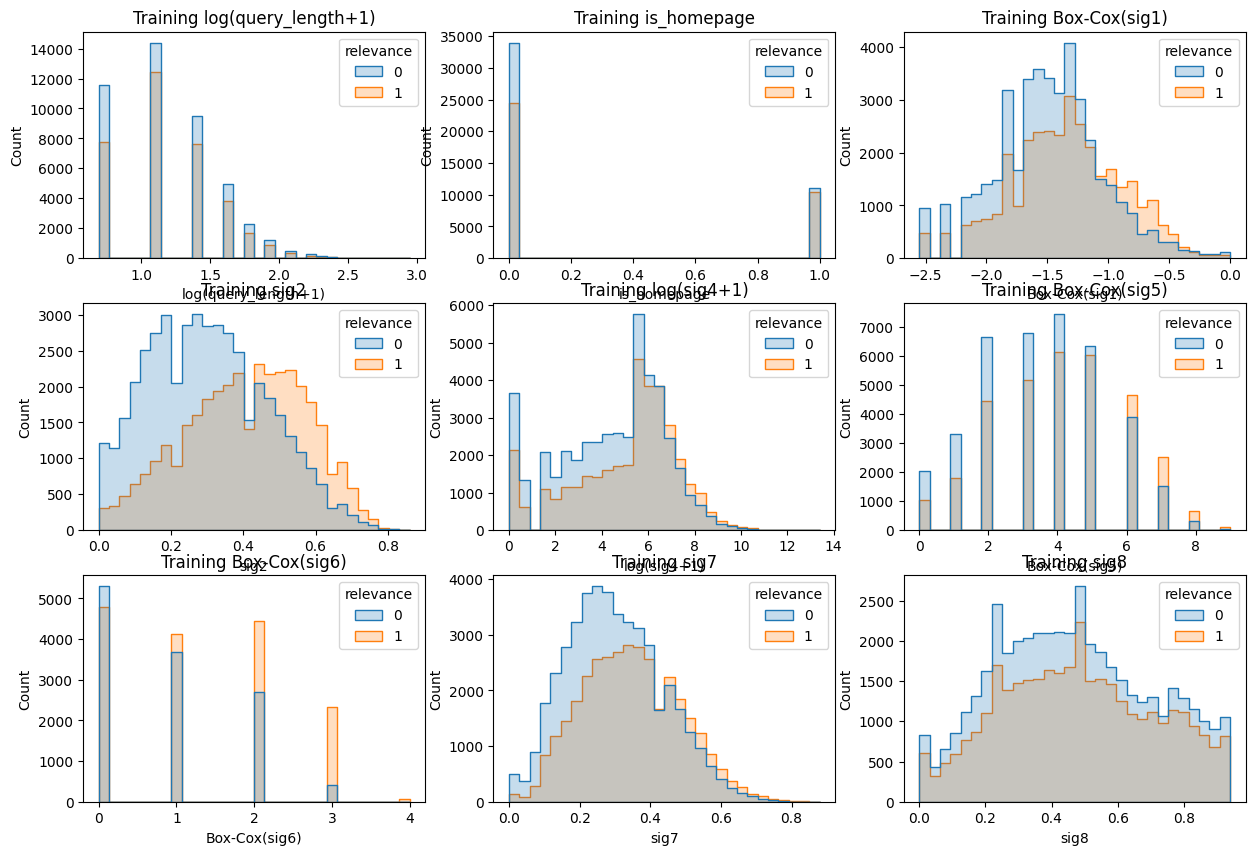

In [3]:
#Take log transform of signals 3,4,5,6
# Assuming df_train is your original dataframe
df_train_transformed = df_train.copy()

# Define the features to plot
features = ['query_length', 'is_homepage', 'sig1', 'sig2', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']

# Apply Box-Cox transformation to sig1, sig5, and sig6
for feature in ['sig1', 'sig5', 'sig6']:
    feature_positive = df_train_transformed[feature][df_train_transformed[feature] > 0]
    transformed_values, _ = stats.boxcox(feature_positive)
    transformed_values = transformed_values.astype(df_train_transformed[feature].dtype)  # Ensure compatibility
    df_train_transformed.loc[df_train_transformed[feature] > 0, f'{feature}_boxcox'] = transformed_values
    df_train_transformed[f'{feature}_boxcox'].fillna(0, inplace=True)

# Create a figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for i, feature in enumerate(features[:9]):  # Limiting to 9 features for the 3x3 grid
    row = i // 3
    col = i % 3
    if feature in ['sig1']:
        sns.histplot(df_train_transformed[df_train_transformed[feature] !=0], x='sig1_boxcox', hue='relevance', bins=30, ax=axes[row, col], element='step')
        axes[row, col].set_title(f'Training Box-Cox({feature})')
        axes[row, col].set_xlabel(f'Box-Cox({feature})')
    elif feature in ['sig4', 'query_length']:
        sns.histplot(df_train_transformed, x=np.log1p(df_train_transformed[feature]), bins=30, hue='relevance', ax=axes[row, col], element='step')
        axes[row, col].set_title(f'Training log({feature}+1)')
        axes[row, col].set_xlabel(f'log({feature}+1)')
    elif feature in ['sig5']:
        sns.histplot(df_train_transformed[df_train_transformed[feature] !=0], x='sig5_boxcox', hue='relevance', bins=30, ax=axes[row, col], element='step')
        axes[row, col].set_title(f'Training Box-Cox({feature})')
        axes[row, col].set_xlabel(f'Box-Cox({feature})')
    elif feature in ['sig6']:
        sns.histplot(df_train_transformed[df_train_transformed[feature] !=0], x='sig6_boxcox', hue='relevance', bins=30, ax=axes[row, col], element='step')
        axes[row, col].set_title(f'Training Box-Cox({feature})')
        axes[row, col].set_xlabel(f'Box-Cox({feature})')
    else:
        sns.histplot(df_train_transformed, x=feature, hue='relevance', bins=30, ax=axes[row, col], element='step')
        axes[row, col].set_title(f'Training {feature}')
        axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Count')

In [4]:
def evaluate_model(model, X_val, y_val, is_stats_model=False, is_sklearn=False, is_neural_net=False, verbose=False):
  
  if is_neural_net:
      probs = model.predict(X_val).flatten()
      predicted_labels = (probs > 0.5).astype(int)
  else:
      probs = model.predict(X_val)
      predicted_labels = probs > 0.5

  # Calculate the ROC curve and AUC
  fpr, tpr, thresholds = roc_curve(y_val, probs)
  roc_auc = roc_auc_score(y_val, probs)

  # Calculate accuracy, precision and recall
  accuracy = accuracy_score(y_val, predicted_labels)
  precision = precision_score(y_val, predicted_labels)
  recall = recall_score(y_val, predicted_labels)
  print(f'Accuracy: {accuracy}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'Area Under the ROC Curve (AUC): {roc_auc}')

  if not verbose:
    return {
        # 'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': roc_auc
    }

  if is_stats_model:
    print(model.summary())

  # Print model coefficients and intercept
  if is_sklearn:
    print("Model Coefficients:")
    for feature, coef in zip(X_val.columns, model.coef_[0]):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {model.intercept_[0]:.4f}")

  # Generate the confusion matrix
  cm = confusion_matrix(y_val, predicted_labels)

  # Plot the confusion matrix
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc='lower right')
  plt.show()

  return {
        # 'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }

In [5]:
def extract_features(df):
    features = ['query_length', 'query_id', 'url_id', 'is_homepage', 'sig1', 'sig2',  'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
    X = df[features].copy()

    # 1. Interaction terms with log transformation for interactions involving sig3, sig4, sig5, and sig6
    # interaction_features = ['query_length', 'is_homepage', 'sig1', 'sig2', 'sig7', 'sig8', 'sig4', 'sig5', 'sig6']
    skewed_features = ['sig4', 'sig5', 'sig6']

    # for i in range(len(interaction_features)):
    #     for j in range(i + 1, len(interaction_features)):
    #         if interaction_features[i] in skewed_features or interaction_features[j] in skewed_features:
    #             interaction_term = X[interaction_features[i]] * X[interaction_features[j]]
    #             #Take log of the PRODUCT of the features
    #             X[f'log_{interaction_features[i]}*{interaction_features[j]}'] = np.log1p(interaction_term)
    #         else:
    #             X[f'{interaction_features[i]}*{interaction_features[j]}'] = X[interaction_features[i]] * X[interaction_features[j]]

    # 2. Log transformation for skewed features
    for feature in skewed_features:
        X[f'log_{feature}'] = np.log1p(X[feature])

    # 3. Create binary feature for sig6
    # X['sig6_binary'] = (X['sig6'] > 0).astype(int)
    # # Extract positive values
    # sig6_positive = X['sig6'][X['sig6'] > 0]

    # # Apply Box-Cox transformation
    # sig6_boxcox, _ = stats.boxcox(sig6_positive)

    # # Create a new column for the Box-Cox transformed values, initializing with 0
    # X['sig6_boxcox'] = 0.0

    # # Update the new column with the transformed values
    # X.loc[X['sig6'] > 0, 'sig6_boxcox'] = sig6_boxcox

    # 4. Binarization for boolean features
    # X['is_homepage_binary'] = X['is_homepage'].astype(int)

    # 5. Aggregation based on 'query_id' (e.g., mean, std, min, max of signals grouped by 'query_id')
    query_group_by_features = ['query_length', 'is_homepage', 'sig1', 'sig2',  'log_sig4', 'log_sig5', 'log_sig6', 'sig7', 'sig8']
    agg_features_query = X.groupby('query_id')[query_group_by_features].agg(['mean', 'std', 'min', 'max']).reset_index()
    agg_features_query.columns = ['_query_'.join(col) for col in agg_features_query.columns]
    agg_features_query.rename(columns={'query_id_query_': 'query_id'}, inplace=True)
    agg_features_query.fillna(0, inplace=True)
    X = X.merge(agg_features_query, left_on='query_id', right_on='query_id', how='left')

    # 5. Aggregation based on 'url_id' (e.g., mean, std, min, max of signals grouped by 'url_id')
    # agg_features_url = df.groupby('url_id')[features].agg(['mean', 'std', 'min', 'max']).reset_index()
    # agg_features_url.columns = ['_url_'.join(col) for col in agg_features_url.columns]
    # agg_features_url.rename(columns={'url_id_url_': 'url_id'}, inplace=True)
    # X = X.merge(agg_features_url, left_on='url_id', right_on='url_id', how='left')

    

    # 6. Create a new feature for query length categorization (1, 2, or more than 2)
    X['query_length_category'] = X['query_length'].apply(lambda x: 1 if x == 1 else 0)

    # 7. Aggregation based on 'query_length_category' (e.g., mean, std, min, max of signals grouped by 'query_length_category')
    # query_length_group_by_features = ['is_homepage', 'sig1', 'sig2',  'log_sig4', 'log_sig5', 'log_sig6', 'sig7', 'sig8']
    # agg_features_query_length = X.groupby('query_length_category')[query_length_group_by_features].agg(['mean', 'std', 'min', 'max']).reset_index()
    # agg_features_query_length.columns = ['_query_length_'.join(col) for col in agg_features_query_length.columns]
    # agg_features_query_length.rename(columns={'query_length_category_query_length_': 'query_length_category'}, inplace=True)
    # agg_features_query_length.fillna(0, inplace=True)
    # X = X.merge(agg_features_query_length, left_on='query_length_category', right_on='query_length_category', how='left')

    # 8. Aggregation based on 'is_homepage' (e.g., mean, std, min, max of signals grouped by 'is_homepage')
    # is_homepage_group_by_features = ['query_length', 'sig1', 'sig2', 'log_sig4', 'log_sig5', 'log_sig6', 'sig7', 'sig8']
    # agg_features_is_homepage = X.groupby('is_homepage')[is_homepage_group_by_features].agg(['mean', 'std', 'min', 'max']).reset_index()
    # agg_features_is_homepage.columns = ['_is_homepage_'.join(col) for col in agg_features_is_homepage.columns]
    # agg_features_is_homepage.rename(columns={'is_homepage_is_homepage_': 'is_homepage'}, inplace=True)
    # X = X.merge(agg_features_is_homepage, left_on='is_homepage', right_on='is_homepage', how='left')

    # 8. Adding polynomial features
    # polynomial_features = ['sig1', 'sig2', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
    # poly = PolynomialFeatures(degree=2, include_bias=False)
    # X_poly = poly.fit_transform(X[polynomial_features])
    # poly_feature_names = poly.get_feature_names_out(polynomial_features)
    # X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X.index)
    # X = pd.concat([X, X_poly_df], axis=1)

    X.drop(columns=['sig4', 'sig5', 'sig6', 'url_id', 'query_id'], inplace=True)

    return X


features = ['query_length', 'query_id', 'url_id', 'is_homepage', 'sig1', 'sig2', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
X = df_train[features].copy()
y = df_train['relevance']

X = extract_features(X)
X_test = df_test[features].copy()
X_test = extract_features(X_test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## LightGBM

In [7]:
from skopt import BayesSearchCV
param_grid = {
    'num_leaves': (20, 35),
    'max_depth': (8, 15),
    'learning_rate': (0.05, 0.1, 'log-uniform'),
    'n_estimators': (400, 800),
    'subsample': (0.5, 0.7, 'uniform'),
    'colsample_bytree': (0.5, 0.6, 'uniform'),
    'min_child_samples': (150, 200)
}

# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier()

# Initialize Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=lgb_model,
    search_spaces=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='roc_auc',
    cv=3,
    verbose=-1,
    random_state=42,
    n_jobs=-1
)

In [34]:
%%time
# Fit the model
bayes_search.fit(X_train_scaled, y_train)

# Get the best model
best_lgb_model = bayes_search.best_estimator_

# Evaluate the best model
evaluate_model(best_lgb_model, X_val_scaled, y_val, "LightGBM with Bayesian Optimization")

# Print best parameters
print("Best parameters found: ", bayes_search.best_params_)
# Best parameters found:  OrderedDict([('colsample_bytree', 0.5538690163226526), ('learning_rate', 0.059900692425716405), ('max_depth', 9), ('min_child_samples', 171), ('n_estimators', 486), ('num_leaves', 30), ('subsample', 0.6017844157743167)])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[LightGBM] [Info] Number of positive: 18686, number of negative: 24005
[LightGBM] [Info] Number of positive: 18686, number of negative: 24005
[LightGBM] [Info] Number of positive: 18686, number of negative: 24006
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6889
[LightGBM] [Info] Number of data points in the train set: 42691, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437703 -> initscore=-0.250488
[LightGBM] [Info] Start training from score -0.250488
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Inf

In [35]:
print("Best parameters found: ", bayes_search.best_params_)

Best parameters found:  OrderedDict([('colsample_bytree', 0.5), ('learning_rate', 0.05), ('max_depth', 10), ('min_child_samples', 150), ('n_estimators', 400), ('num_leaves', 20), ('subsample', 0.7)])


In [29]:
# Initialize LightGBM model with previously found best parameters
best_params = {
    'colsample_bytree': 0.5538690163226526,
    'learning_rate': 0.08024335972011515,
    'max_depth': 9,
    'min_child_samples': 171,
    'n_estimators': 486,
    'num_leaves': 30,
    'subsample': 0.6017844157743167,
    'verbosity': -1,
    'random_state':42
}
best_lgb_model = lgb.LGBMClassifier(**best_params)

# Train the model
best_lgb_model.fit(X_train_scaled, y_train)

# Evaluate the model using the existing evaluate_model function
lgb_base_metrics = evaluate_model(best_lgb_model, X_val_scaled, y_val, is_stats_model=False, verbose=False)

ValueError: sample_weight.shape == (64036,), expected (71152,)!

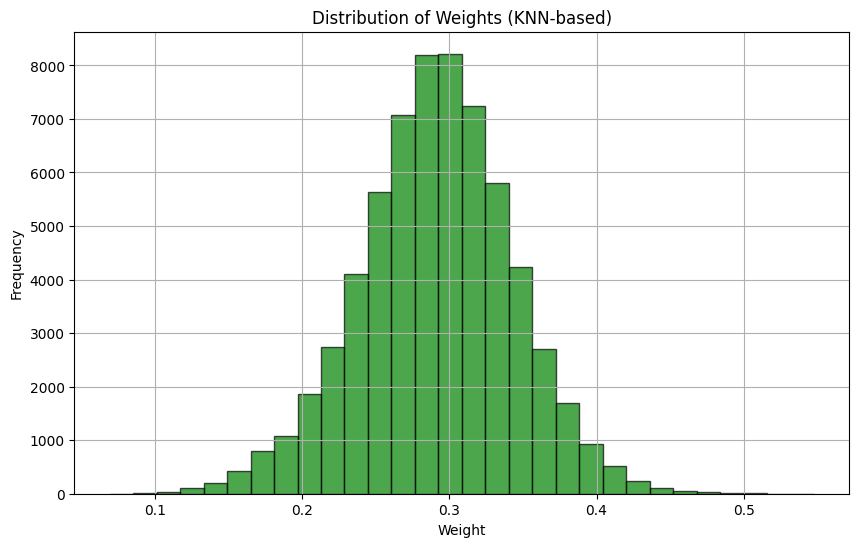

In [17]:
# Let's fit our training set weights to our test set (Hack the Kaggle Comp....)
from sklearn.neighbors import NearestNeighbors

# Fit Nearest Neighbors on the test set
nn = NearestNeighbors(n_neighbors=5)  # Choose k based on your preference
nn.fit(X_test_scaled)

# Find the nearest neighbors in the test set for each training sample
distances, _ = nn.kneighbors(X_train_scaled)

# Calculate weights as the inverse of the average distance to the nearest neighbors
weights = 1 / np.mean(distances, axis=1)

# Plot the distribution of the weights
plt.figure(figsize=(10, 6))
plt.hist(weights, bins=30, color='green', edgecolor='black', alpha=0.7)
plt.title('Distribution of Weights (KNN-based)')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Cross Validation

In [40]:
from sklearn.model_selection import KFold

features = ['query_length', 'query_id', 'url_id', 'is_homepage', 'sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
X = df_train[features].copy()
y = df_train['relevance']

X = extract_features(X)
X_test = df_test[features].copy()
X_test = extract_features(X_test)
X.head()

# Initialize KFold with 5 splits
kf = KFold(n_splits=9, shuffle=True, random_state=42)

# Lists to store results
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train the model
    best_lgb_model.fit(X_train_scaled, y_train)

    # Evaluate the model
    evaluation_results = evaluate_model(best_lgb_model, X_val_scaled, y_val, "LightGBM with Hyperparameter Tuning")

    # Store results
    accuracy_scores.append(float(evaluation_results['accuracy']))
    precision_scores.append(float(evaluation_results['precision']))
    recall_scores.append(float(evaluation_results['recall']))
    auc_scores.append(float(evaluation_results['auc']))

# Calculate mean and standard deviation of the metrics
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

# Print the results
print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"AUC: {mean_auc:.4f} ± {std_auc:.4f}")
print(f"Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Recall: {mean_recall:.4f} ± {std_recall:.4f}")

Accuracy: 0.6904654823476502
Precision: 0.6840739539409666
Recall: 0.5424382716049383
Area Under the ROC Curve (AUC): 0.6739358757145747
Accuracy: 0.7001349224196087
Precision: 0.6876011654257042
Recall: 0.5551489806586514
Area Under the ROC Curve (AUC): 0.6823692811738402
Accuracy: 0.6984483921744996
Precision: 0.69
Recall: 0.5664443304258594
Area Under the ROC Curve (AUC): 0.6839427416740986
Accuracy: 0.6929390600404767
Precision: 0.6921288608435736
Recall: 0.5360082304526749
Area Under the ROC Curve (AUC): 0.6754152218983311
Accuracy: 0.6992354396222172
Precision: 0.7031847133757961
Recall: 0.5588458618071375
Area Under the ROC Curve (AUC): 0.6851481989594053
Accuracy: 0.6950753316842815
Precision: 0.6937438584998362
Recall: 0.5437740693196406
Area Under the ROC Curve (AUC): 0.6783683309190721
Accuracy: 0.6988981335731954
Precision: 0.6918199112238428
Recall: 0.5612139917695473
Area Under the ROC Curve (AUC): 0.6835234960845339
Accuracy: 0.6936136721385203
Precision: 0.6819610307982

In [39]:
#Train final model with ALL of training data
features = ['query_length', 'query_id', 'url_id', 'is_homepage', 'sig1', 'sig2', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
X = df_train[features].copy()
y = df_train['relevance']

best_params = {
    'colsample_bytree': 0.5538690163226526,
    'learning_rate': 0.08024335972011515,
    'max_depth': 9,
    'min_child_samples': 171,
    'n_estimators': 486,
    'num_leaves': 30,
    'subsample': 0.6017844157743167,
    'verbosity': -1,
    'random_state':42
}

best_lgb_model = lgb.LGBMClassifier(**best_params)



X = extract_features(X)
X_all_train_scaled = scaler.fit_transform(X)

distances, _ = nn.kneighbors(X_all_train_scaled)
# Calculate weights as the inverse of the average distance to the nearest neighbors
weights = 1 / np.mean(distances, axis=1)

best_lgb_model.fit(X_all_train_scaled, y, sample_weight=weights)

# This is interesting. The training accuracy is only 0.759. I would think this would be higher. 
evaluation_results = evaluate_model(best_lgb_model, X_all_train_scaled, y, "LightGBM with Hyperparameter Tuning")

Accuracy: 0.7650101191814707
Precision: 0.7854395313547659
Recall: 0.636150570211793
Area Under the ROC Curve (AUC): 0.7506081864130716


## Test Set

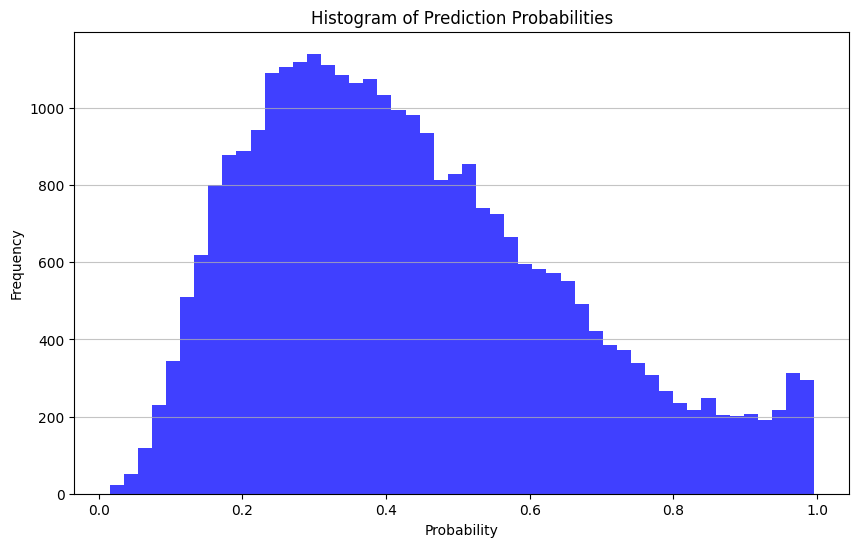

In [40]:
# Generate prediction probabilities using the trained model
prediction_probs = best_lgb_model.predict_proba(X_test_scaled)[:, 1]


# Plot a histogram of the prediction probabilities
plt.figure(figsize=(10, 6))
plt.hist(prediction_probs, bins=50, alpha=0.75, color='blue')
plt.title('Histogram of Prediction Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [42]:
predictions = best_lgb_model.predict(X_test_scaled)
submission_df = pd.DataFrame({'id': df_test['id'], 'relevance': predictions})
submission_df.to_csv('submission8.csv', index=False)
submission_df.head()

,id,relevance
0,0.0,0
1,1.0,0
2,2.0,0
3,3.0,0
4,51.0,0


In [14]:
#Lets see how different our submissions are
submission1 = pd.read_csv('submission.csv')
submission2 = pd.read_csv('submission3.csv')

# Compare the 'relevance' column
comparison = submission1['relevance'].compare(submission2['relevance'])

# Show the comparison results
print(comparison)

       self  other
24      1.0    0.0
27      0.0    1.0
32      0.0    1.0
37      1.0    0.0
40      1.0    0.0
...     ...    ...
29928   0.0    1.0
29940   1.0    0.0
29945   0.0    1.0
29988   1.0    0.0
29992   0.0    1.0

[2678 rows x 2 columns]


## XGBoost

In [27]:
import xgboost as xgb

# These hyperparameters were tuned below.
best_params_xgb = {
    'colsample_bytree': 0.7089249740105412,
    'gamma': 0.0556072502957811,
    'learning_rate': 0.01,
    'max_depth': 15,
    'min_child_weight': 6,
    'n_estimators': 759,
    'random_state': 42,
    'subsample': 0.4
}

xgb_model = xgb.XGBClassifier(**best_params_xgb)
xgb_model.fit(X_train_scaled, y_train)
evaluate_model(xgb_model, X_val_scaled, y_val, "XGBoost")

Accuracy: 0.6949406620861961
Precision: 0.6836626676076217
Recall: 0.556273327591157
Area Under the ROC Curve (AUC): 0.6790101710932344


{'accuracy': 0.6949406620861961,
 'precision': np.float64(0.6836626676076217),
 'recall': np.float64(0.556273327591157),
 'auc': np.float64(0.6790101710932344)}

In [ ]:
# Fit the model
param_ranges = {
    'colsample_bytree': (0.4, 0.9),
    'subsample': (0.4, 0.9),
    'learning_rate': (0.01, 0.3),  # This range will be log-uniform by default
    'max_depth': (3, 15),
    'n_estimators': (100, 1000),
    'min_child_weight': (1, 10),
    'gamma': (0.0, 0.5),
    'random_state': [42]  # Fixed value
}

# Initialize XGBoost model
xgb_model = xgb.XGBClassifier()

# Initialize Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_ranges,
    n_iter=50,  # Number of parameter settings sampled
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=0,
    random_state=42
)


In [ ]:
# Takes 13 minutes to run
# bayes_search.fit(X_train_scaled, y_train)

# # Get the best model
# best_xgb_model = bayes_search.best_estimator_

# Evaluate the best model
# evaluate_model(xgb_model, X_val_scaled, y_val, "XGBoost with Bayesian Optimization")

# Print best parameters
# print("Best parameters found: ", bayes_search.best_params_)

In [28]:
from sklearn.model_selection import KFold

features = ['query_length', 'query_id', 'url_id', 'is_homepage', 'sig1', 'sig2', 'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
X = df_train[features].copy()
y = df_train['relevance']

X = extract_features(X)

# Initialize KFold with 5 splits
kf = KFold(n_splits=9, shuffle=True, random_state=42)

# Lists to store results
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

# Perform K-Fold Cross-Validation
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train the model
    best_xgb_model.fit(X_train_scaled, y_train)

    # Evaluate the model
    evaluation_results = evaluate_model(best_xgb_model, X_val_scaled, y_val, "XGBoost with Hyperparameter Tuning")

    # Store results
    accuracy_scores.append(float(evaluation_results['accuracy']))
    precision_scores.append(float(evaluation_results['precision']))
    recall_scores.append(float(evaluation_results['recall']))
    auc_scores.append(float(evaluation_results['auc']))

# Calculate mean and standard deviation of the metrics
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
mean_precision = np.mean(precision_scores)
std_precision = np.std(precision_scores)
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

# Print the results
print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"AUC: {mean_auc:.4f} ± {std_auc:.4f}")
print(f"Precision: {mean_precision:.4f} ± {std_precision:.4f}")
print(f"Recall: {mean_recall:.4f} ± {std_recall:.4f}")

Accuracy: 0.6947380256352598
Precision: 0.6869620656678355
Recall: 0.5542695473251029
Area Under the ROC Curve (AUC): 0.6790524724240377
Accuracy: 0.703283112210479
Precision: 0.6881141045958795
Recall: 0.5674333507579717
Area Under the ROC Curve (AUC): 0.6866369595147397
Accuracy: 0.7033955475601529
Precision: 0.6939655172413793
Recall: 0.5782452539763981
Area Under the ROC Curve (AUC): 0.6896430433212655
Accuracy: 0.6963121205306948
Precision: 0.6951660637948044
Recall: 0.543724279835391
Area Under the ROC Curve (AUC): 0.6792732465896891
Accuracy: 0.701484146615696
Precision: 0.7016179215930305
Recall: 0.5707415844090103
Area Under the ROC Curve (AUC): 0.6883649253220451
Accuracy: 0.701371711266022
Precision: 0.698876404494382
Recall: 0.5589216944801026
Area Under the ROC Curve (AUC): 0.6856420834873007
Accuracy: 0.7023836294130875
Precision: 0.6942097026604069
Recall: 0.5704732510288066
Area Under the ROC Curve (AUC): 0.6876537249950266
Accuracy: 0.694288284236564
Precision: 0.67996

In [36]:
#Train final model with ALL of training data
features = ['query_length', 'query_id', 'url_id', 'is_homepage', 'sig1', 'sig2', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
X = df_train[features].copy()
y = df_train['relevance']

best_xgb_model = lgb.LGBMClassifier(**best_params_xgb)

X = extract_features(X)
X_all_train_scaled = scaler.fit_transform(X)
best_xgb_model.fit(X_all_train_scaled, y)

# This is interesting. The training accuracy is only 0.759. I would think this would be higher. 
evaluation_results = evaluate_model(best_xgb_model, X_all_train_scaled, y, "XGBoost with Hyperparameter Tuning")

Accuracy: 0.7088049371611324
Precision: 0.7197425861809423
Recall: 0.5466316060250951
Area Under the ROC Curve (AUC): 0.690679703676122


In [37]:
predictions = best_xgb_model.predict(X_test_scaled)
submission_df = pd.DataFrame({'id': df_test['id'], 'relevance': predictions})
submission_df.to_csv('submission7.csv', index=False)
submission_df.head()

,id,relevance
0,0.0,0
1,1.0,0
2,2.0,0
3,3.0,0
4,51.0,0


In [16]:
# !kaggle competitions submit -c stanford-stats-202-prediction-2024 -f submission3.csv -m "Fit train to test set"

Traceback (most recent call last):
  File "/Users/henrydaniels-koch/miniforge3/envs/stats_202_proj/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/Users/henrydaniels-koch/miniforge3/envs/stats_202_proj/lib/python3.10/site-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/Users/henrydaniels-koch/miniforge3/envs/stats_202_proj/lib/python3.10/site-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /Users/henrydaniels-koch/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
